<a href="https://colab.research.google.com/github/hiydavid/tfdev_learning/blob/main/ZTM/notebooks/tfdev_04_transfer_learning_feature_exrtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Transfer Learning Feature Extraction

In this notebook we'll:

* Introduce transfer learning
* Build a transfer learning feature extraction model using TensorFlow Hub
* Introduce the TensorBoard callback to track model training results
* Compare model results using TensorBoard

# Get Data

In [1]:
# download data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-03-21 13:38:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.203.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   184MB/s    in 0.9s    

2022-03-21 13:38:13 (184 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# see explore folders of images
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

# Creating Dataloaders

In [3]:
# create dataloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Testing images:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Callbacks

* TensorBoard: `tf.keras.callbacks.TensorBoard()`
* Model checkpointing: `tf.keras.callbacks.ModelCheckpoint()`
* Early stopping: `tf.keras.callbacks.EarlyStopping()`
* Learning rate scheduler: `tf.keras.callbacks.LearningRateScheduler()` -- *already covered*

In [4]:
# create tensorboard callback
from datetime import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

# Build Models with TensorFlow Hub

In [5]:
# import
import tensorflow_hub as hub
import tensorflow as tf

In [6]:
# get urls
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# make a create_model function
def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False, # freeze the pretrained weights
        input_shape=IMAGE_SHAPE + (3,)
    )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(
            num_classes, 
            activation="softmax",
            name="output_layer"
        )
    ])

    return model

# Build a Pre-Trained ResNet Model

In [12]:
# create and testing resnet
resnet_model = create_model(
    resnet_url,
    num_classes=train_data_10_percent.num_classes
)

In [13]:
# get summary
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# compile & fit pretrained model
resnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

hist_resnet = resnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="resnet50v2"
    )]
)

Saving TensorBoard log file to tensorflow_hub/resnet50v2/20220321-134355
Epoch 1/5
24/24 [==============================] - 31s 991ms/step - loss: 1.8362 - accuracy: 0.3747 - val_loss: 1.2312 - val_accuracy: 0.6092
Epoch 2/5
24/24 [==============================] - 22s 934ms/step - loss: 0.8817 - accuracy: 0.7387 - val_loss: 0.8630 - val_accuracy: 0.7224
Epoch 3/5
24/24 [==============================] - 22s 963ms/step - loss: 0.6023 - accuracy: 0.8360 - val_loss: 0.7687 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 23s 987ms/step - loss: 0.4549 - accuracy: 0.8853 - val_loss: 0.7065 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3609 - accuracy: 0.9213 - val_loss: 0.6928 - val_accuracy: 0.7696


In [15]:
# create a function to plot loss curve
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

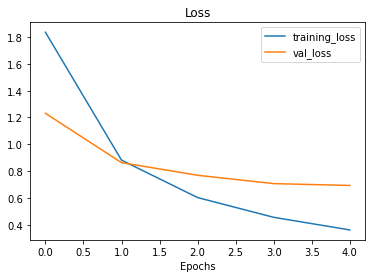

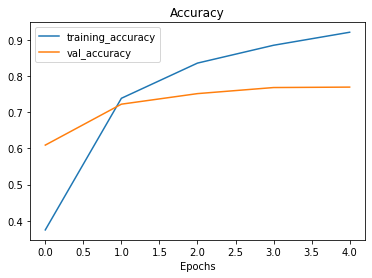

In [16]:
# plot
plot_loss_curves(hist_resnet)

# Build a Pre-Trained EfficientNet Model

In [18]:
# create, compile, fit efficientnet
efficientnet_model = create_model(
    efficientnet_url,
    num_classes=train_data_10_percent.num_classes
)

efficientnet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

hist_efficientnet = efficientnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="efficientnetb0"
    )]
)

Saving TensorBoard log file to tensorflow_hub/efficientnetb0/20220321-134726
Epoch 1/5
24/24 [==============================] - 34s 917ms/step - loss: 1.8701 - accuracy: 0.4173 - val_loss: 1.2991 - val_accuracy: 0.7340
Epoch 2/5
24/24 [==============================] - 20s 837ms/step - loss: 1.0689 - accuracy: 0.7653 - val_loss: 0.8737 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 19s 828ms/step - loss: 0.7633 - accuracy: 0.8307 - val_loss: 0.6978 - val_accuracy: 0.8492
Epoch 4/5
24/24 [==============================] - 19s 834ms/step - loss: 0.6122 - accuracy: 0.8693 - val_loss: 0.6122 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 20s 846ms/step - loss: 0.5180 - accuracy: 0.8893 - val_loss: 0.5594 - val_accuracy: 0.8664


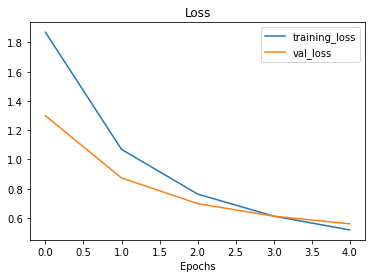

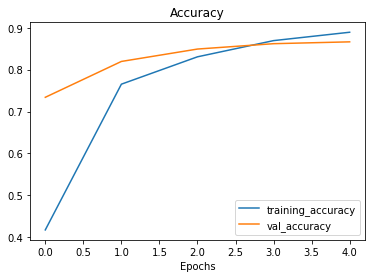

In [19]:
# plot
plot_loss_curves(hist_efficientnet)

# Compare Models with TensorBoard